In [1]:
import numpy as np
import copy
from scipy.signal import argrelextrema
from skimage.feature import peak_local_max

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
#CODATA 2017
kB = 1.38064903E-23  #J/K
Na = 6.022140758E+23 #1/mol

In [3]:
#Necessary Packages
#import numpy as np
#import copy
#from scipy.signal import argrelextrema

class FHMC_Analysis:
    def __init__(self,lnZ0,V,beta,Debug=False,Extrapolated=False):
        self.N = np.array([])
        self.lnPi = np.array([])
        self.energy = np.array([])
        self.energy2 = np.array([])
        self.lnZ0 = lnZ0
        self.V = V
        self.beta = beta
        self.Debug = Debug
        self.Extrapolated = Extrapolated
    def CheckTail_func(self,threshold):
        #maxima = argrelextrema( self.lnPi, np.greater )
        maxima = peak_local_max( self.lnPi )[0]
        delta = np.abs(self.lnPi[int(maxima[-1])] - self.lnPi[-1])
        if delta < threshold:
            return False
        else:
            return True    
    def reweight(self,lnZ_rw, Normalize=False, Output=False, CheckTail=False):
        # Reweighting operation
        lnPi_temp = self.lnPi + self.N*(lnZ_rw-self.lnZ0)
        # Shift relative to max value
        lnPi_temp = lnPi_temp - max(lnPi_temp)
        # Normalize, if desired
        if Normalize: lnPi_temp = lnPi_temp - np.log( np.sum( np.exp(lnPi_temp) ) )
        # Create a child object and replace the lnPi and lnZ
        child = copy.deepcopy(self) # double ensure that the child is a new object, not a pointer
        child.lnZ0 = lnZ_rw
        child.lnPi = np.array(lnPi_temp)
        # Check the tail of the distribution
        if CheckTail:
            if not child.CheckTail_func(threshold=10.0):
                raise Exception('\nReweighted to lnZ = '+str(lnZ_rw)+'\n' \
                                'Insufficient Tail \n')

        return child
    def temperature_extrapolate(self,beta_extrap, order=1, Normalize=False, CheckTail=False):
        if self.Extrapolated:
            raise Exception('\nNO NO NO\nDo not extrapolate already-extrapolated lnPi!')
        mu = self.lnZ0/self.beta
        if order < 1:
            raise Exception('\nExtrapolation Order = '+str(order)+' not possible\n' \
                                'Check your input data')
        #First Order Extrapolation
        lnPi_temp = self.lnPi + (beta_extrap - self.beta)*(mu*self.N - self.energy)
        #NOTE: Inconsequential terms were skipped; they are all independent of N
        #      and so do not affect the relative values of Pi
        if order == 2:
            #Second Order Extrapolation            
            lnPi_temp = lnPi_temp + 0.50 * ((beta_extrap - self.beta)**2)*(self.energy2 - (self.energy)**2)
            #NOTE: As for first order extrap, inconsequential terms were skipped
        if order > 2:
            raise Exception('\nExtrapolation Order = '+str(order)+' not possible\n' \
                                'Check your input data')
        #Normalize, if desired
        if Normalize: lnPi_temp = lnPi_temp - np.log( np.sum( np.exp(lnPi_temp) ) )
        # Create a child object and replace the lnPi, lnZ and beta
        child = copy.deepcopy(self) # double ensure that the child is a new object, not a pointer
        child.beta = beta_extrap
        child.lnZ0 = self.lnZ0*beta_extrap/self.beta
        child.lnPi = lnPi_temp
        child.Extrapolated = True
        # Check the tail of the distribution
        if CheckTail:
            if not child.CheckTail_func(threshold=10.0):
                raise Exception('\nExtrapolated to beta = '+str(beta_extrap)+'\n' \
                                'Insufficient Tail')
        return child
    def phase_boundaries(self):
        #maxima = argrelextrema( self.lnPi, np.greater, order=10 )
        maxima = peak_local_max( self.lnPi )[0]
        if len(maxima) == 1:
            Nbound = self.N[-1]
            phases = 1
        elif ln(maxima) == 2:
            #minima = argrelextrema( self.lnPi, np.less, order=10 )
            minima = peak_local_max( -self.lnPi )[0]
            Nbound = int(minima[0])
            phases = 2
        else:
            raise Exception('\nMore than two maxima in lnPi\n'+\
                            'Current lnZ = '+str(self.lnZ))                       
        return phases, Nbound

    #Function for computing ensemble properties
    def ensemble_properties(self):
        Pi = np.exp( self.lnPi - max( self.lnPi ) )
        denom = np.sum( Pi )
        Navg = np.dot( self.N, Pi )/denom
        N2avg = np.dot( (self.N)**2, Pi )/denom
        Uavg = np.dot( self.energy, Pi )/denom
        U2avg = np.dot( self.energy2, Pi )/denom
        UNavg = np.dot( np.multiply(self.N,self.energy), Pi )/denom
        #Determine a better way to output all of these moments
        return Navg,N2avg,Uavg,U2avg,UNavg
    
    #Function for computing phase properties
    def phase_properties(self):
        # Phase-specific properties
        phases, Nbound = self.phase_boundaries()
        #Create lists for properties computation
        Navg = [ [0. for x in range(phases)] for i in range(2) ]
        Uavg = [0. for x in range(phases)]
        UNavg = [0. for x in range(phases)]
        for i in range(phases):
            #NOTE: the "numpy.multiply" function is the "Hadamard" Product,
            # e.g., element-wise multiplication of two tensors of the same rank;
            # it yields a tensor of the same rank as the input tensors
            if i == 0:
                #  Shift lnPi to prevent round-off truncation in lnPi -> Pi conversion
                Pi = np.exp( self.lnPi - max( self.lnPi[:Nbound] ) )
                denom = np.sum( Pi[:Nbound] )
                for j in range(2):
                    Navg[j][i] = np.dot( self.N[:Nbound]**(j+1), Pi[:Nbound] )/denom
                Uavg[i] = np.dot( self.energy[:Nbound], Pi[:Nbound] )/denom
                UNavg[i] = np.dot( np.multiply(self.N[:Nbound],self.energy[:Nbound]),Pi[:Nbound] )/denom
            elif i == 1:
                #  Shift lnPi to prevent round-off truncation in lnPi -> Pi conversion
                Pi = np.exp( self.lnPi - max( self.lnPi[Nbound+1:]) )
                denom = np.sum( Pi[Nbound+1:] )
                for j in range(2):
                    Navg[i] = np.dot( self.N[Nbound+1:]**(j+1), Pi[Nbound+1:] )/denom
                Uavg[i] = np.dot( self.energy[Nbound+1:], Pi[Nbound+1:] )/denom
                UNavg[i] = np.dot( np.multiply(self.N[Nbound+1:],self.energy[Nbound+1:]),Pi[Nbound+1:] )/denom            
        return Navg,Uavg,UNavg

    def grand_potential(self):
        # Phase-specific properties
        phases, Nbound = self.phase_boundaries()
        # Create list
        Omega = [0. for x in range(phases)]
        for i in range(phases):
            if i == 0:
                #  Shift lnPi to prevent round-off truncation in lnPi -> Pi conversion
                Pi = np.exp( self.lnPi - max( self.lnPi[:Nbound] ) )
                Omega[i]=( (np.log(Pi[0]) - np.sum(Pi[:Nbound]))/self.beta )
            elif i == 1:
                #  Shift lnPi to prevent round-off truncation in lnPi -> Pi conversion
                Pi = np.exp( self.lnPi - max( self.lnPi[Nbound+1:]) )
                Omega[i]=( (np.log(Pi[0]) - np.sum(Pi[Nbound+1:]))/self.beta )
        return Omega

    def pressure(self):
        return [-x/self.V for x in self.grand_potential()]

    def canonical_entropy_ex(self):
        Sx = self.lnPi - self.lnPi[0] + self.beta*self.energy - self.lnZ0*self.N
        return np.array(Sx)

    def grandcanonical_entropy_ex(self):
        Sx = self.canonical_entropy_ex()
        Pi = np.exp( self.lnPi - max( self.lnPi ) )
        denom = np.sum( Pi )
        Sx_gc = np.dot( Sx, Pi )/denom
        return Sx_gc
    
    def grandcanonical_entropy_ex_phases(self):
        Sx = self.canonical_entropy_ex()
        phases, Nbound = self.phase_boundaries()
        #Create lists for properties computation
        Sx_gc = [0. for x in range(phases)]
        for i in range(phases):
            #NOTE: the "numpy.multiply" function is the "Hadamard" Product,
            # e.g., element-wise multiplication of two tensors of the same rank;
            # it yields a tensor of the same rank as the input tensors
            if i == 0:
                #  Shift lnPi to prevent round-off truncation in lnPi -> Pi conversion
                Pi = np.exp( self.lnPi - max( self.lnPi[:Nbound] ) )
                denom = np.sum( Pi[:Nbound] )
                Sx_gc[i] = np.dot( Sx[:Nbound], Pi[:Nbound] )/denom
            elif i == 1:
                #  Shift lnPi to prevent round-off truncation in lnPi -> Pi conversion
                Pi = np.exp( self.lnPi - max( self.lnPi[Nbound+1:]) )
                denom = np.sum( Pi[Nbound+1:] )
                Sx_gc[i] = np.dot( Sx[Nbound+1:], Pi[Nbound+1:] )/denom
        return Sx_gc

In [4]:
# Data Abstraction [this is code-specific]
src = '/mnt/WS_PN107151/dsideriu/Research/Monte_Carlo/my_FEASST/activity_check/argon_LJ'
MC_output = 'colMat'

with open(src+'/'+MC_output,mode='r') as f:
    text_in = f.readlines()

    
for (lineID,line) in enumerate(text_in):
    if (line.split()[1] == 'lnz'):
        lnZ = float(line.split()[2])
    elif (line.split()[1] == 'beta'):
        beta = float(line.split()[2])
        T = 1./beta
    #print(line.strip('\n'))
    elif ("macrostate" in line.split()[1]): #macrostate data is after this
        macro_data = text_in[(lineID+1):]
        
#SEEMS LIKE THERE SHOULD BE A BETTER WAY TO DO THIS...
#  WHY DO I NEED TO CREATE PYTHON LISTS, THEN CONVERT THEM TO NumPy ARRAYS?
N = np.array( [ int(x.split()[0]) for x in macro_data ] )
lnPi = np.array( [ float(x.split()[1]) for x in macro_data ] )
#energy = np.array( [ float(x.split()[2]) for x in macro_data ] )
energy = np.array( [ float(x.split()[9])/float(x.split()[8]) for x in macro_data ] )
energy = energy - energy[0]
energy2 = np.array( [ float(x.split()[10])/float(x.split()[8]) for x in macro_data ] )


# Instantiate the confined fluid data object
bulk_real = FHMC_Analysis(lnZ,1.,beta)
bulk_real.N = N
bulk_real.lnPi = lnPi
bulk_real.energy = energy
bulk_real.energy2 = energy2

In [15]:
# Data Abstraction [this is code-specific]
src = '/mnt/WS_PN107151/dsideriu/Research/Monte_Carlo/my_FEASST/activity_check/generic_LJ'
MC_output = 'colMat'

with open(src+'/'+MC_output,mode='r') as f:
    text_in = f.readlines()

    
for (lineID,line) in enumerate(text_in):
    if (line.split()[1] == 'lnz'):
        lnZ = float(line.split()[2])
    elif (line.split()[1] == 'beta'):
        beta = float(line.split()[2])
        T = 1./beta
    #print(line.strip('\n'))
    elif ("macrostate" in line.split()[1]): #macrostate data is after this
        macro_data = text_in[(lineID+1):]
        
#SEEMS LIKE THERE SHOULD BE A BETTER WAY TO DO THIS...
#  WHY DO I NEED TO CREATE PYTHON LISTS, THEN CONVERT THEM TO NumPy ARRAYS?
N = np.array( [ int(x.split()[0]) for x in macro_data ] )
lnPi = np.array( [ float(x.split()[1]) for x in macro_data ] )
#energy = np.array( [ float(x.split()[2]) for x in macro_data ] )
energy = np.array( [ float(x.split()[9])/float(x.split()[8]) for x in macro_data ] )
energy = energy - energy[0]
energy2 = np.array( [ float(x.split()[10])/float(x.split()[8]) for x in macro_data ] )

#Convert the activity, temperature, and energy
sigma_LJ = 3.405 #Angstromgs
eps_LJ = 119.80 #K
lnZ = lnZ - 3.*np.log(sigma_LJ)
beta = beta/eps_LJ/kB/Na * 1.e3
energy = energy * eps_LJ * kB * Na / 1.e3

# Instantiate the confined fluid data object
bulk_generic = FHMC_Analysis(lnZ,1.,beta)
bulk_generic.N = N
bulk_generic.lnPi = lnPi
bulk_generic.energy = energy
bulk_generic.energy2 = energy2

In [16]:
print(bulk_real.lnZ0, bulk_real.beta)
print(bulk_generic.lnZ0, bulk_generic.beta)

-3.0 1.115492134
-6.675734818804427 1.1154920465336198


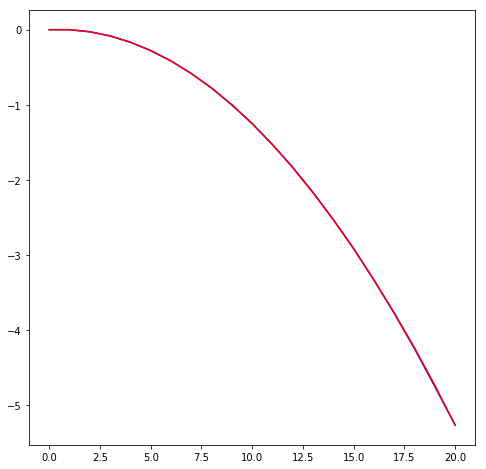

In [17]:
fig = plt.figure(figsize=(8,8))
plt.plot(bulk_real.N, bulk_real.energy, 'b')
plt.plot(bulk_generic.N, bulk_generic.energy, 'r')
plt.show()

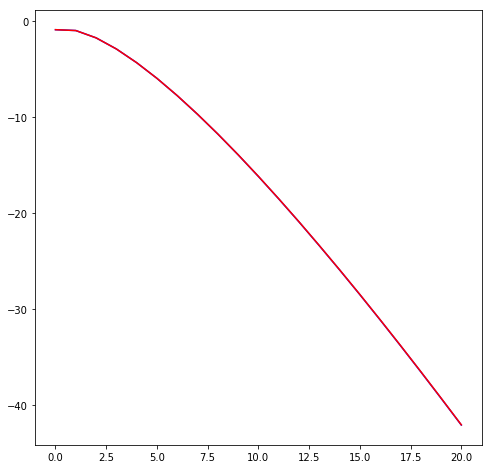

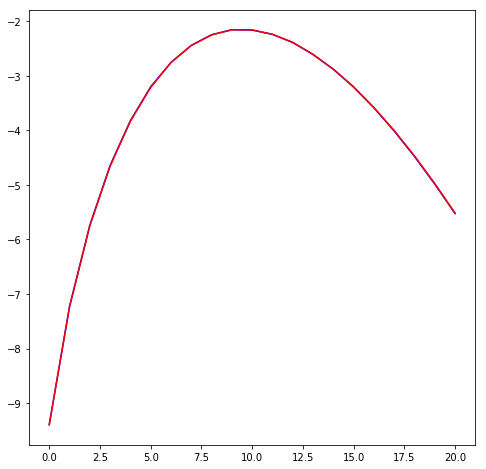

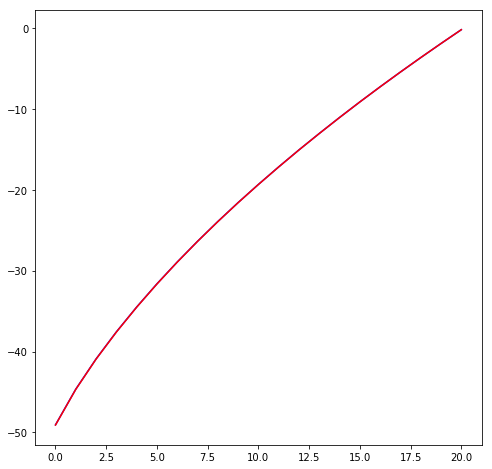

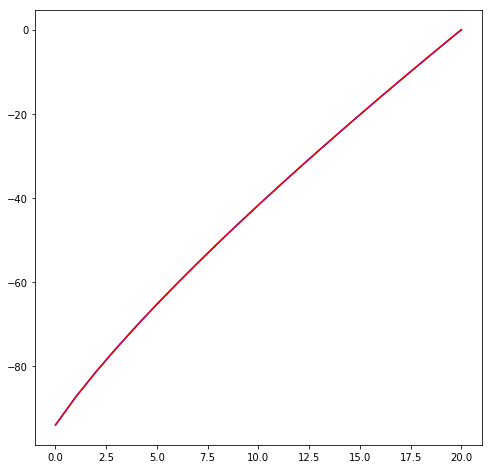

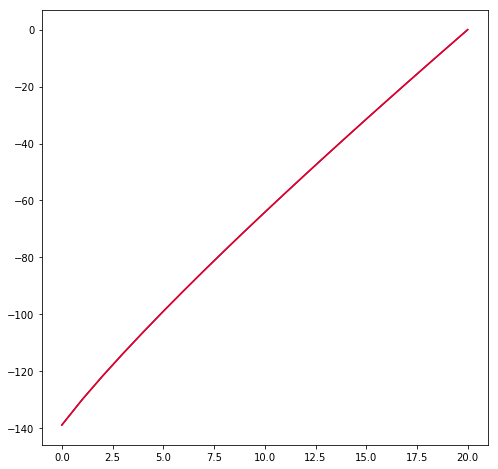

In [18]:
for lnZ_rw in np.linspace(-10., -1., 5):
    new1 = bulk_real.reweight(lnZ_rw,Normalize=True)
    new2 = bulk_generic.reweight(lnZ_rw,Normalize=True)
    
    fig = plt.figure(figsize=(8,8))
    plt.plot(new1.N, new1.lnPi, 'b')
    plt.plot(new2.N, new2.lnPi, 'r')
    plt.show()